## Finding the best place in Toronto to open an Indian restaurant
                                (Battle of Neighborhoods)

Importing required libraries

In [68]:
import pandas as pd # importing pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup # importing BeautifulSoup, a web scraping library
import numpy as np # importing numpy
from sklearn.cluster import KMeans
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt

 ## 1. Scraping and Exploring Dataset
 
 
 extracting tabular data from wikipedia page and storing it into pandas dataframe df
 
 There are different website scraping libraries and packages in Python. One of the most common packages is BeautifulSoup and we'll be using this library for this assignment

In [2]:
res = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0] 
df = pd.read_html(str(table))

The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood. 
The cells with a borough that is Not assigned will be ignored.
If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.

providing the column header to the dataframe

In [3]:
df1=df[0][0:][1:]
df1.columns=['PostalCode','Borough','Neighborhood']# giving the column header to the df1 dataframe
df1.head()

,PostalCode,Borough,Neighborhood
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Harbourfront


The above dataframe contains 'Not assigned' Borough and it has to be removed from this data frame

Removing the rows with 'Not assigned' Borough

In [4]:
df2=df1[df1['Borough']!='Not assigned'].reset_index(drop=True) # Removing the rows with 'Not assigned' Borough
df2.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


The dataframe df2 has same multiple Postal Codes and associated neighborhoods. So Rows will be grouped for the same postal code and the neighborhood will be separated by comma

In [5]:
df3=df2.groupby(['PostalCode','Borough'], as_index=False).agg(lambda x: ','.join(x)) #grouping the rows for same postal code
df3.head(12)

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park"
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge"
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff,Cliffside West"


If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. So for the 9th cell in the table on the Wikipedia page, the value of the Borough and the Neighborhood columns will be Queen's Park.

Assigning the borough to the neighborhood where neighborhood is 'Not assigned'

In [6]:
not_assigned_neighborhood = df3.Neighborhood == 'Not assigned'
df3.loc[not_assigned_neighborhood, 'Neighborhood'] = df3.loc[not_assigned_neighborhood, 'Borough']#Assigning the borough to the neighborhood where neighborhood is 'Not assigned'

In [7]:
df3[not_assigned_neighborhood]

,PostalCode,Borough,Neighborhood
85,M7A,Queen's Park,Queen's Park


In [8]:
df3.shape # checking the dimension of df3 dataframe

(103, 3)

In [9]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

Now that we have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.
In this module we will use the Geocoder Python package.The problem with this Package is you have to be persistent sometimes in order to get the geographical coordinates of a given postal code. So you can make a call to get the latitude and longitude coordinates of a given postal code and the result would be None, and then make the call again and you would get the coordinates. So, in order to make sure that you get the coordinates for all of our neighborhoods, you can run a while loop for each postal code. To avoid complications we will be moving forward with the given coordinate file.

Importing the file containing Latitude and Longotude

In [10]:
df_geo_cord=pd.read_csv('G:/Geospatial_Coordinates.csv')#Importing the coordinate file containing Latitude and Longotude
df_geo_cord.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [11]:
df4=df3.join(df_geo_cord, rsuffix='Latitude, Longitude')# Joining the two dataframe
df5=df4[['PostalCode','Borough','Neighborhood','Latitude','Longitude']]
df5.head(12)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff,Cliffside West",43.692657,-79.264848


## 2. Exploring the neighborhoods in Toronto

In [12]:
address = 'Toronto'
geolocator = Nominatim(user_agent="toronto neighborhood")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('Geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

Geograpical coordinates of Toronto are 43.653963, -79.387207.


In [13]:
radius = 500
LIMIT = 100
CLIENT_ID='Removed'
CLIENT_SECRET='Removed'
VERSION='Removed'
venues = []
for lat, long, post, borough, neighborhood in zip(df5['Latitude'], df5['Longitude'], df5['PostalCode'], df5['Borough'], df5['Neighborhood']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    results = requests.get(url).json()
    results=results["response"]['groups'][0]['items']
    for venue in results:
        venues.append((
            post, 
            borough,
            neighborhood,
            lat, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [16]:
toronto_venues = pd.DataFrame(venues)
toronto_venues.columns = ['PostalCode', 'Borough', 'Neighborhood', 'Borough Latitude', 'Venue Name', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
print(toronto_venues.shape)
toronto_venues.head()

(2245, 8)


,PostalCode,Borough,Neighborhood,Borough Latitude,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,M1B,Scarborough,"Rouge,Malvern",43.806686,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,Royal Canadian Legion,43.782533,-79.163085,Bar
2,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,Scarborough Historical Society,43.788755,-79.162438,History Museum
3,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
4,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,G & G Electronics,43.765309,-79.191537,Electronics Store


Let's check how many venues were returned for each neighborhood

In [70]:
toronto_venues_count=toronto_venues.groupby('Neighborhood').count()
toronto_venues_count

,PostalCode,Borough,Borough Latitude,Venue Name,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,
"Adelaide,King,Richmond",100,100,100,100,100,100,100
Agincourt,4,4,4,4,4,4,4
"Agincourt North,L'Amoreaux East,Milliken,Steeles East",2,2,2,2,2,2,2
"Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown",12,12,12,12,12,12,12
"Alderwood,Long Branch",10,10,10,10,10,10,10
"Bathurst Manor,Downsview North,Wilson Heights",18,18,18,18,18,18,18
Bayview Village,4,4,4,4,4,4,4
"Bedford Park,Lawrence Manor East",24,24,24,24,24,24,24
Berczy Park,55,55,55,55,55,55,55


Let's find out how many unique categories can be curated from all the returned venues

In [18]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 275 uniques categories.


## 3. Analyzing Each Neighborhood

In [126]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Rock Climbing Spot,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

let's examine the new dataframe size.

In [20]:
toronto_onehot.shape

(2245, 275)

let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [21]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Rock Climbing Spot,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,"Adelaide,King,Richmond",0.000000,0.010000,0.000000,0.00

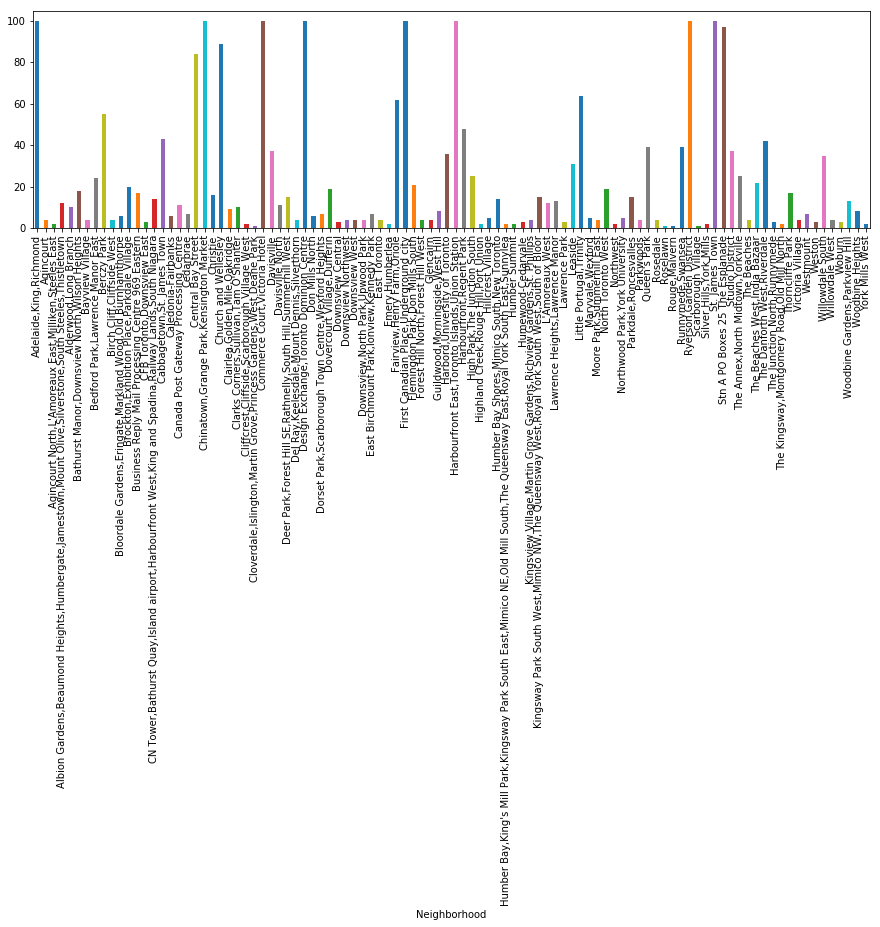

In [124]:
nbd1=toronto_venues_count['Venue Category']
#nbd2=toronto_grouped['Neighborhood']
#nbd1.plot(kind='bar')
#plt.show()
plt.figure(figsize=(15,4))
nbd1.plot(kind='bar')
plt.show()

Let's extract and sort in descending order the mean of frequency of occurrence of Indian restaurant for each neighborhood

In [128]:
df_ind_rest=toronto_grouped['Indian Restaurant'].sort_values(ascending=False)
df_ind_rest.head(20)

34    0.285714
90    0.117647
7     0.041667
84    0.040000
28    0.027027
87    0.023810
19    0.023810
15    0.023256
22    0.011236
81    0.010000
0     0.010000
50    0.010000
38    0.000000
32    0.000000
27    0.000000
44    0.000000
29    0.000000
43    0.000000
30    0.000000
31    0.000000
Name: Indian Restaurant, dtype: float64

## 4. KMeans Clustering

Let's divide the neighborhoods based on their mean of frequency of occurrence into three clusters.

In [64]:
cntr=np.array([0.2, 0.03, 0]).reshape(-1,1)# initilization of center coordinates
X=df_ind_rest.values.reshape(-1, 1)
kmeans=KMeans(init = cntr,n_clusters = 3, n_init = 12)
kmeans.fit(X)

C:\Users\mahe\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=12
  return_n_iter=True)


KMeans(algorithm='auto', copy_x=True,
    init=array([[0.2 ],
       [0.03],
       [0.  ]]), max_iter=300,
    n_clusters=3, n_init=12, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [66]:
# getting labels for each neighborhood
kmeans_labels = kmeans.labels_
kmeans_labels

array([0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [67]:
# getting center coordinates each cluster
cl=kmeans.cluster_centers_
cl

array([[0.20168067],
       [0.02992809],
       [0.00044822]])

The data is divided into three clusters with centers at 0.20168067, 0.02992809 and 0.00044822
top two neighborhoods are grouped into cluster label 0, next top 6 are grouped into cluster label 1. and rest are grouped into cluster label 2.

Dorset Park,Scarborough Town Centre,Wexfordare are the neighborhoods where mean frequency is highest 0.285714 followed by Thorncliffe Park on the second number 0.117647.
So the best place to open Indian Restaurant would be Dorset Park, Scarborough Town Centre, Wexfordareand Thorncliffe Park